#Import and Basic Settings

In [462]:
import os as os
os.getcwd()


'/Users/mario/Documents/Github/Education.ai/notebooks'

*Analyse the metrics described in the paper*
- Total funding,
- Description
- Age [extract date - funding date]
- Acqisition (made, aquired); Who aquired it?

In [463]:
#import libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [464]:
'''
#mount drive
from google.colab import drive
drive.mount('1LbVccBPxo8pR9C41wosD5qYOglKsDrPr')
'''

"\n#mount drive\nfrom google.colab import drive\ndrive.mount('1LbVccBPxo8pR9C41wosD5qYOglKsDrPr')\n"

In [465]:
#import processed dataset
df = pd.read_csv("//Users/mario/Documents/Github/Education.ai/data/2022-12-31_EdTech dataset_processed.csv", index_col=0)

/var/folders/sv/wh2gxdqd7l7g9jyshkbzflxr0000gn/T/ipykernel_2057/2151554003.py:2: DtypeWarning: Columns (78,104,107) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("//Users/mario/Documents/Github/Education.ai/data/2022-12-31_EdTech dataset_processed.csv", index_col=0)


In [466]:
#basic setting for plot layout
sns.set_theme(style= 'darkgrid' )#"whitegrid")
plt.rcParams.update({'font.size': 22})
my_colors = 'Set1' #'flag' #'brg'   #'BrBG_r' # "ch:r=-.2,d=.3_r" 

In [467]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14046 entries, 0 to 14045
Columns: 125 entries, Organization Name to Class
dtypes: bool(1), float64(36), int64(4), object(84)
memory usage: 13.4+ MB


In [468]:
for i in df.columns: print(i)

Organization Name
Organization Name URL
Founded Date
Founded Date Precision
Industries
Headquarters Location
Description
CB Rank (Company)
Estimated Revenue Range
Operating Status
Exit Date
Exit Date Precision
Closed Date
Closed Date Precision
Company Type
Website
Twitter
LinkedIn
Full Description
Facebook
Headquarters Regions
Investment Stage
Investor Type
Number of Portfolio Organizations
Number of Investments
Number of Lead Investments
Number of Diversity Investments
Number of Exits
Number of Exits (IPO)
Accelerator Program Type
Accelerator Application Deadline
Accelerator Duration (in weeks)
School Type
School Program
Number of Enrollments
School Method
Number of Founders (Alumni)
Industry Groups
Number of Founders
Founders
Number of Employees
Number of Funding Rounds
Funding Status
Last Funding Date
Last Funding Amount
Last Funding Amount Currency
Last Funding Amount Currency (in USD)
Last Funding Type
Last Equity Funding Amount
Last Equity Funding Amount Currency
Last Equity Fund

#Formating Data for Analysis

In [469]:
#defining age calculation
from datetime import date

cut_off = date(2022, 12, 31)

def calculateAge(x):
    t0 = cut_off
    age = t0.year - x.year -((t0.month, t0.day) <
         (x.month, x.day))

    return age

In [470]:
#define a age calculation with a continous value
def calculateAgeDays(x):
  t0 = cut_off
  age = sum([(t0.year- x.year) * 365.25, (t0.month - x.month) * 30, (t0.day - x.day)])

  return age

In [471]:
#converting str in 'Founded Date' to datetime format
from pandas.core.reshape.tile import to_datetime
df['Founded Date'] = to_datetime(df['Founded Date'])

/var/folders/sv/wh2gxdqd7l7g9jyshkbzflxr0000gn/T/ipykernel_2057/1797541815.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Founded Date'] = to_datetime(df['Founded Date'])


In [472]:
#generating 'Age' col from 'Founded Date' col
df['Age'] = df.apply(lambda row : calculateAge(row['Founded Date']), axis = 1)

In [473]:
df['Age in Days'] = df.apply(lambda row : calculateAgeDays(row['Founded Date']), axis = 1)

In [474]:
#split the location cell into actionable parts
df[['City','Country']]  = df['Headquarters Location'].str.rsplit(r",", n=1, expand=True)

In [475]:
#The 'Industries' field offers companies/ data curators the option to specify AI in a profile, extract boolean value for said field
df['Class self-identified'] = df['Industries'].str.contains('Artificial Intelligence', regex= False)

In [476]:
#define a function to turn numbers wrongfully identified as dates back into the classification buckets
def emp_corr(var):
  i = str(var)
  if i == '01.Oct':
    return '1-10'
  elif i =='Nov.50':
    return '11-50'
  else:
    return var

In [477]:
#apply the above function to the 'Number of Employees' column
df['Number of Employees'] = df.apply(lambda row : emp_corr(row['Number of Employees']), axis = 1)

#Origin Country of Ventures
Check if findings of Dalle et al. (2017) hold true for the dataset
- mostly US-based *(how is it worded exactlly? majority or just biggest part?)*



In [478]:
#count the values for Countries
countries = df['Country'].value_counts()

In [479]:
#print top 10 countries of origin (overview as appendix)
countries[:10]

Country
 United States      6405
 India              1951
 United Kingdom     1231
 France              357
 Germany             342
 Spain               327
 China               314
 Israel              218
 Switzerland         192
 The Netherlands     190
Name: count, dtype: int64

In [480]:
#reshape 'countries Series' for better visibility in the plot
#the top 10
countries_plt= countries[:10].copy()

#append 'others' category
others = pd.Series({' Others' : countries[10:].sum()})
countries_plt = pd.concat([countries_plt,(others)])

#add column names
countries_plt = pd.DataFrame(countries_plt, copy = True, columns = ['# Ventures'])
countries_plt = countries_plt.reset_index(names='Country')

In [481]:
#insert a column with the ISO 3166 Alpha-3 code for country names to increase readability
countries_plt['Origin'] = ['USA', 'IND', 'GBR', 'FRA','DEU', 'ESP', 'CHN','ISR', 'CHE', 'NLD','others']

In [482]:
#calculate the sample size
countries_plt['# Ventures'].sum()

14004

/var/folders/sv/wh2gxdqd7l7g9jyshkbzflxr0000gn/T/ipykernel_2057/1470902161.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'Origin' , y = '# Ventures', data = countries_plt, palette= my_colors,)


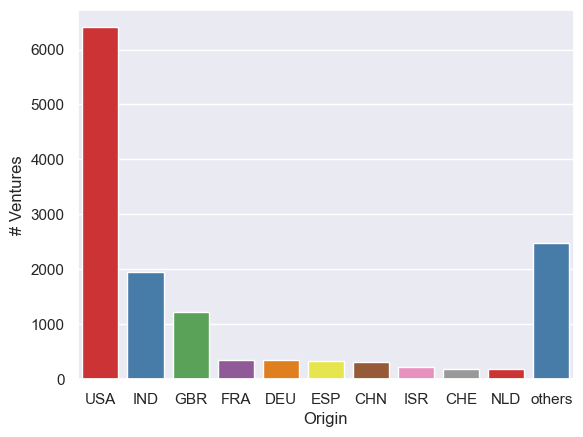

In [483]:
# bar plot
sns.barplot(x = 'Origin' , y = '# Ventures', data = countries_plt, palette= my_colors,)
plt.show()

Note: the assumption found in theory seems to hold true

#Size of Ventures
- mostly small (<50 FTE) firms in sample.

In [484]:
#count the values for small firms
size = df['Number of Employees'].value_counts()

In [485]:
size

Number of Employees
1-10          6987
11-50         4619
51-100         720
101-250        483
251-500        217
501-1000       103
1001-5000       71
10001+          32
5001-10000      16
Name: count, dtype: int64

In [486]:
#calculate the sample size
size.sum()

13248

In [487]:
#calculate percentage of ventures with less than 50 employees
(size['1-10']+ size['11-50'])/size.sum()

0.8760567632850241

#Survival Rate of Ventures

In [488]:
#Import .xlsx with Data from Statista
df_sr = pd.read_excel("/Users/mario/Documents/Github/Education.ai/data/survival-rates.xlsx",
                    sheet_name = 0)

In [489]:
df_sr['Sample Count'] = df['Age'].value_counts()

In [490]:
survivors = df[df['Operating Status']== 'Active']
df_sr['Sample Survivors'] = survivors['Age'].value_counts()

In [491]:
#calculate the survival rate
df_sr['Sample'] = (df_sr['Sample Survivors'] / df_sr['Sample Count']) * 100

Text(0.5, 0, 'Age')

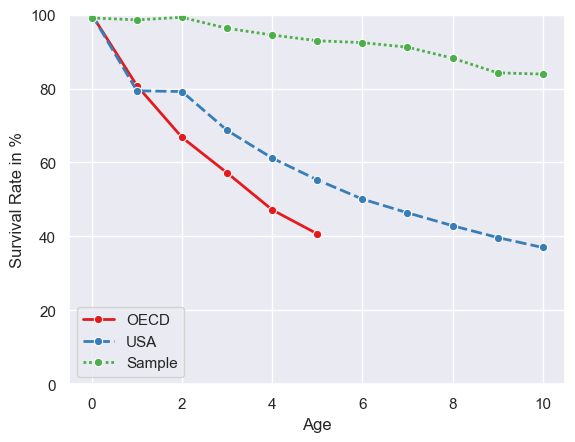

In [492]:
sr_plt = sns.lineplot(data = df_sr[['OECD','USA','Sample']],
                      palette = my_colors,
                      linewidth = 2,
                      marker='o',
                      linestyle= '--')
sr_plt.set_ylim(0, 100)
sr_plt.set_ylabel('Survival Rate in %')
sr_plt.set_xlabel('Age')

Note: OECD values are older; the US rates show the 'Corona-Freeze' in bankrupcy observed also in other economies

Furthermore, bias identified (survivor/ "publsihing bias" ) in Retterath & Braun 2020

In [493]:
'''
# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset
f, ax = plt.subplots(figsize=(16.5, 16.5))
sns.despine(f, left=True, bottom=True)
#ai_binary = {0: 'non-AI', 1: 'AI'}
size_ranking = ['10001+','5001-10000','1001-5000' ,'501-1000','251-500','101-250','51-100','11-50','1-10']
sns.scatterplot(y="Total Funding Amount Currency (in USD)", x= 'Age in Days',#alt:"Age"
                hue="Operating Status", size="Number of Employees",
                palette= my_colors,
                #hue_order= ai_binary,
                size_order = size_ranking,
                sizes=(10, 400), linewidth=0,
                alpha=.5,
                data=df, ax=ax)
plt.yscale('log')
'''

'\n# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset\nf, ax = plt.subplots(figsize=(16.5, 16.5))\nsns.despine(f, left=True, bottom=True)\n#ai_binary = {0: \'non-AI\', 1: \'AI\'}\nsize_ranking = [\'10001+\',\'5001-10000\',\'1001-5000\' ,\'501-1000\',\'251-500\',\'101-250\',\'51-100\',\'11-50\',\'1-10\']\nsns.scatterplot(y="Total Funding Amount Currency (in USD)", x= \'Age in Days\',#alt:"Age"\n                hue="Operating Status", size="Number of Employees",\n                palette= my_colors,\n                #hue_order= ai_binary,\n                size_order = size_ranking,\n                sizes=(10, 400), linewidth=0,\n                alpha=.5,\n                data=df, ax=ax)\nplt.yscale(\'log\')\n'

#Industry Tags (Self-Identification)

In [494]:
#analyse overlap own classification vs. AI; ML Tag in Industry/Verticals column

#Topic Model (Unsupervised Learning)

In [495]:
df['Name'].value_counts()

Name
-1_learning_students_platform_education       8352
0_children_kids_parents_games                  698
1_entrepreneurs_startup_startups_business      589
2_college_students_universities_university     435
3_services_solutions_development_business      375
4_language_english_learning_languages          370
5_sports_fitness_athletes_coaches              332
6_career_job_talent_candidates                 258
7_coding_code_programming_learn                244
8_books_reading_book_readers                   213
9_reality_vr_virtual_ar                        210
10_education_students_online_educational       202
11_financial_loan_money_loans                  195
12_medical_healthcare_health_medicine          181
13_tutors_tutoring_tutor_students              171
14_video_users_content_videos                  168
15_writing_writers_essay_assignment            166
16_school_academy_education_schools            147
17_learning_teachers_students_data             143
18_education_chinese_china

8352 entries could not be fitted into a categorie of more than 100 entries. Topic '-1' is thus dropped from the analysis. See BERTopic documentation.

In [496]:
#rename columns to be more descriptive
df['Topic Name'] = df['Name']

In [497]:
#Exclude Topic '-1' from analysis
topic_df = df[df['Topic']!= -1]

<Figure size 640x480 with 0 Axes>

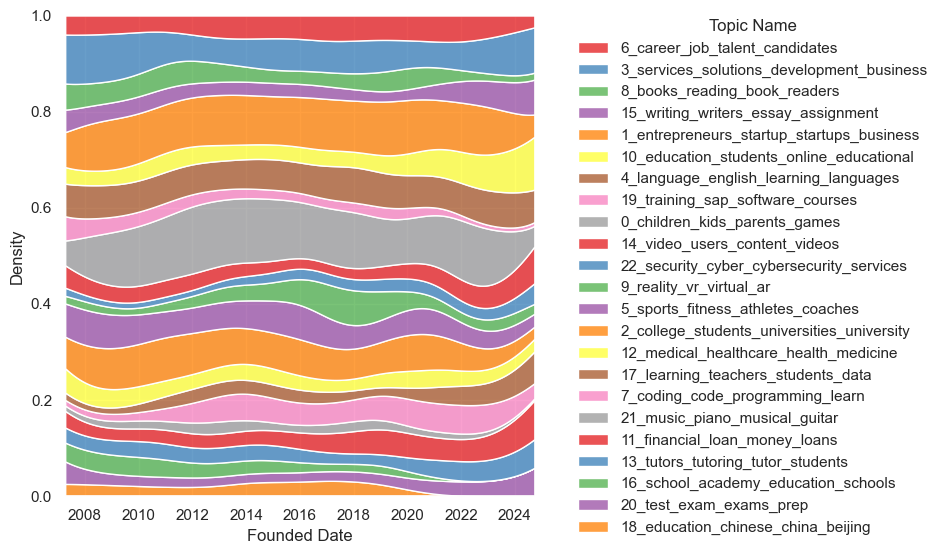

In [498]:

sns.despine(left=True, bottom=True)

sns.displot(
    data=topic_df,
    x='Founded Date' ,#'Age in Days',#"Age"
    hue="Topic Name",
    kind="kde", height=6,
    multiple="fill", clip=(0, None),
    palette= my_colors,
)

Topics worth investigating:
Expansion in 10, 15, 17
Decreased interest in 8, 9
Complete drop-off in 16, 18, 19

*Notes, possible Explanations:*

8: Books -> market saturation, shrinking, unatractive market?

9: VR -> META effect? resp. market trend influencing META

10: online education -> Coronoa Boom

15: writting -> LLM integrations -> possible AI link

16: -> moves with 18, same explanation?

17: -> follows 10, learning moved online, better data availabillity 

18: China banned education apps

19: Software training -> Market saturation?

Thus seems to rather follow macro-trends, than technological topics

In [499]:
'''
# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset
f, ax = plt.subplots(figsize=(16.5, 16.5))
sns.despine(f, left=True, bottom=True)
#ai_binary = {0: 'non-AI', 1: 'AI'}
size_ranking = ['10001+','5001-10000','1001-5000' ,'501-1000','251-500','101-250','51-100','11-50','1-10']
sns.scatterplot(y="Total Funding Amount Currency (in USD)",
                x= 'Age in Days',#alt:"Age"
                hue="Topic",
                size="Number of Employees",
                palette= my_colors,
                #hue_order= ai_binary,
                size_order = size_ranking,
                sizes=(10, 400),
                linewidth=0,
                alpha=.5,
                data=df, ax=ax)
plt.yscale('log')
'''

'\n# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset\nf, ax = plt.subplots(figsize=(16.5, 16.5))\nsns.despine(f, left=True, bottom=True)\n#ai_binary = {0: \'non-AI\', 1: \'AI\'}\nsize_ranking = [\'10001+\',\'5001-10000\',\'1001-5000\' ,\'501-1000\',\'251-500\',\'101-250\',\'51-100\',\'11-50\',\'1-10\']\nsns.scatterplot(y="Total Funding Amount Currency (in USD)",\n                x= \'Age in Days\',#alt:"Age"\n                hue="Topic",\n                size="Number of Employees",\n                palette= my_colors,\n                #hue_order= ai_binary,\n                size_order = size_ranking,\n                sizes=(10, 400),\n                linewidth=0,\n                alpha=.5,\n                data=df, ax=ax)\nplt.yscale(\'log\')\n'

In [500]:
Rep_Doc = df[df['Representative_document']== True]

In [501]:
#create an export with the relevant columns to add as an appendix, showing the comapny name, the original description, the assigned topic and representative words
topic_export = (Rep_Doc[['Organization Name','Full Description','Topic Name', 'Top_n_words']])
topic_export.to_csv('//Users/mario/Documents/Github/Education.ai/data/topic_model_exports.csv')

#Classification

In [502]:
df['Class'].value_counts()

Class
0    12976
1     1070
Name: count, dtype: int64

In [503]:
df['Class self-identified'].value_counts()

Class self-identified
False    13550
True       496
Name: count, dtype: int64

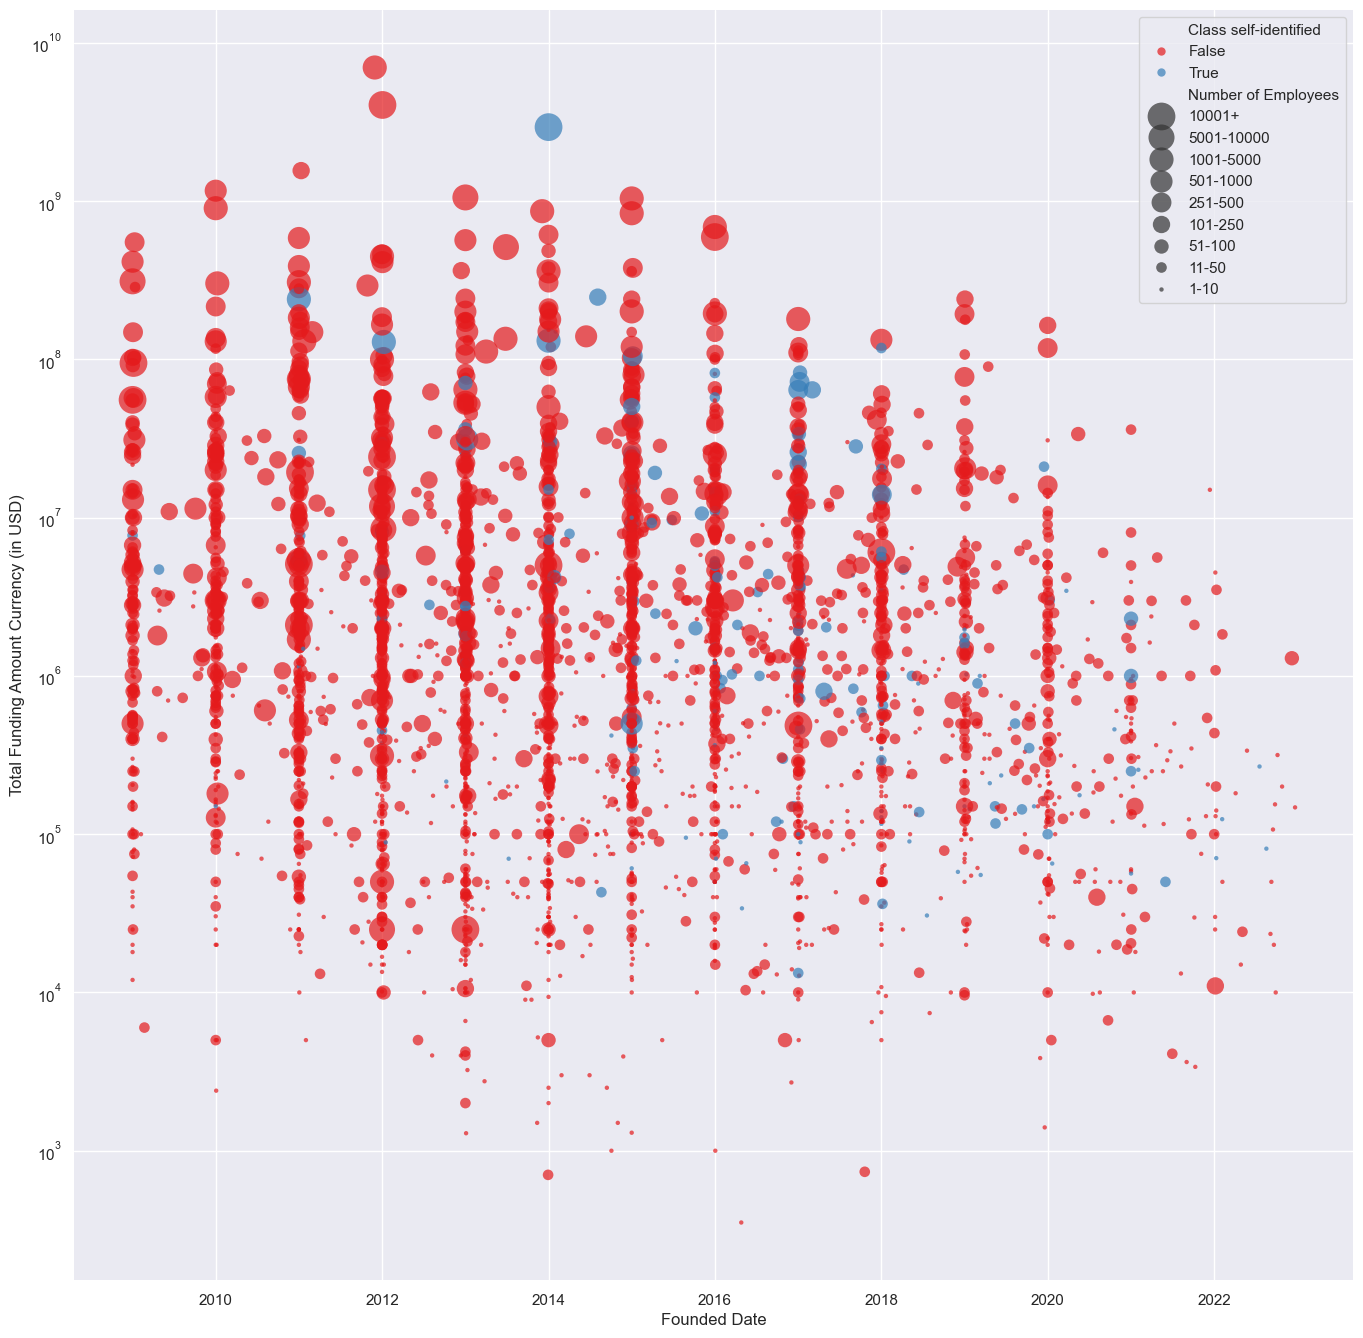

In [508]:
# Draw a scatter plot while assigning point colors and sizes to different variables in the dataset
f, ax = plt.subplots(figsize=(16.5, 16.5))
sns.despine(f, left=True, bottom=True)
#ai_binary = {0: 'non-AI', 1: 'AI'}
size_ranking = ['10001+','5001-10000','1001-5000' ,'501-1000','251-500','101-250','51-100','11-50','1-10']
sns.scatterplot(y="Total Funding Amount Currency (in USD)", x= 'Founded Date', #'Age in Days', #"Age"
                hue= 'Class self-identified' ,  #"Class"
                size="Number of Employees",
                palette= my_colors,
                #hue_order= ai_binary,
                size_order = size_ranking,
                sizes=(10, 400), linewidth=0,
                alpha=.7,
                data=df, ax=ax)
plt.yscale('log')

Notes:
1. Data Quality: a lot of entry dates coincide with the new years, quality is improving
2. AI companies see to be spread out randomly
3. as expected big, well-funded orgs are older (top left) -> seems valid

<Axes: >

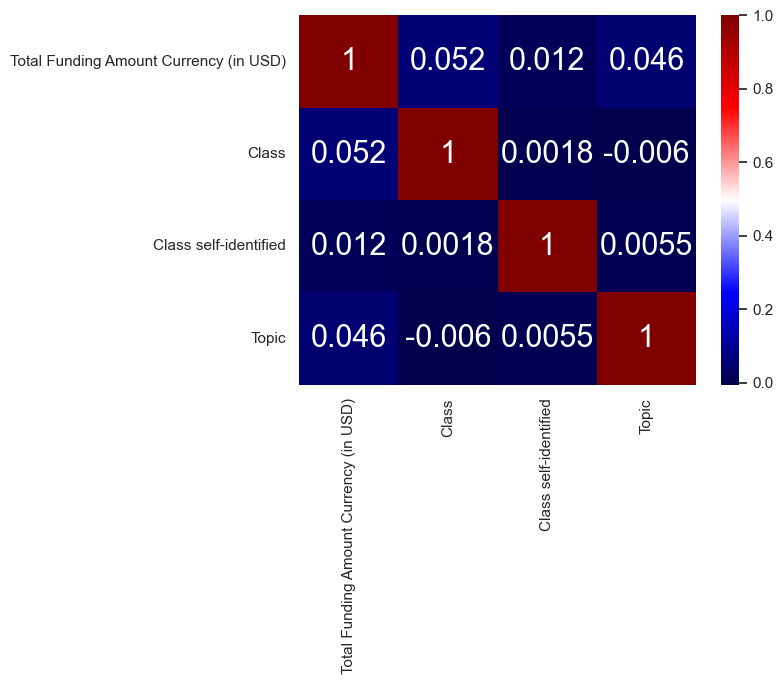

In [509]:
#checking for corellation between analysed var and Total Funding
sns.heatmap(df[['Total Funding Amount Currency (in USD)', 'Class', 'Class self-identified',  'Topic']].corr(), 
            annot= True,
            cmap = 'seismic'
            )

very low correlation for all analysed variables (Topic, AI, AI self-described)

These var do not correlate with successfull fundraising, the idea of Cooper et al. could not be replicated for the EdTech market